In [35]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [36]:
TRAIN = True
EPOCHS = 25

In [37]:
if not os.path.exists('train'):
    !curl -L "https://public.roboflow.com/ds/xKLV14HbTF?key=aJzo7msVta" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    
    dirs = ['test', 'train', 'valid']

    for i, dir_name in enumerate(dirs):
        all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
        for j, image_name in enumerate(all_image_names):
            if (j % 2) == 0:
                file_name = image_name.split('.jpg')[0]
                os.remove(f"{dir_name}/images/{image_name}")
                os.remove(f"{dir_name}/labels/{file_name}.txt")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   1391      0 --:--:-- --:--:-- --:--:--  1399
100 38.4M  100 38.4M    0     0  4717k      0  0:00:08  0:00:08 --:--:-- 6737k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg  
 extracting: test/images/00dea1edf14f09ab_jpg.rf.KJ730oDTFPdXdJxvSLnX.jpg  
 extracting: test/images/00e481ea1a520175_jpg.rf.6e6a8b3b45c9a11d106958f88ff714ea.jpg  
 extracting: test/images/00e481ea1a520175_jpg.rf.MV6sZ8QCFwFeMYaI2tHm.jpg  
 extracting: test/images/08c8b73e0c2e296e_jpg.rf.7IkYAamjZhnwsoXSrwKt.jpg  
 extracting: test/images/08c8b73e0c2e296e_jpg.rf.effa65856584463c08848031cab357b9.jpg  
 extractin

In [38]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

In [39]:
class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [40]:

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [41]:
def plot_box(image, bboxes, labels):
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [42]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

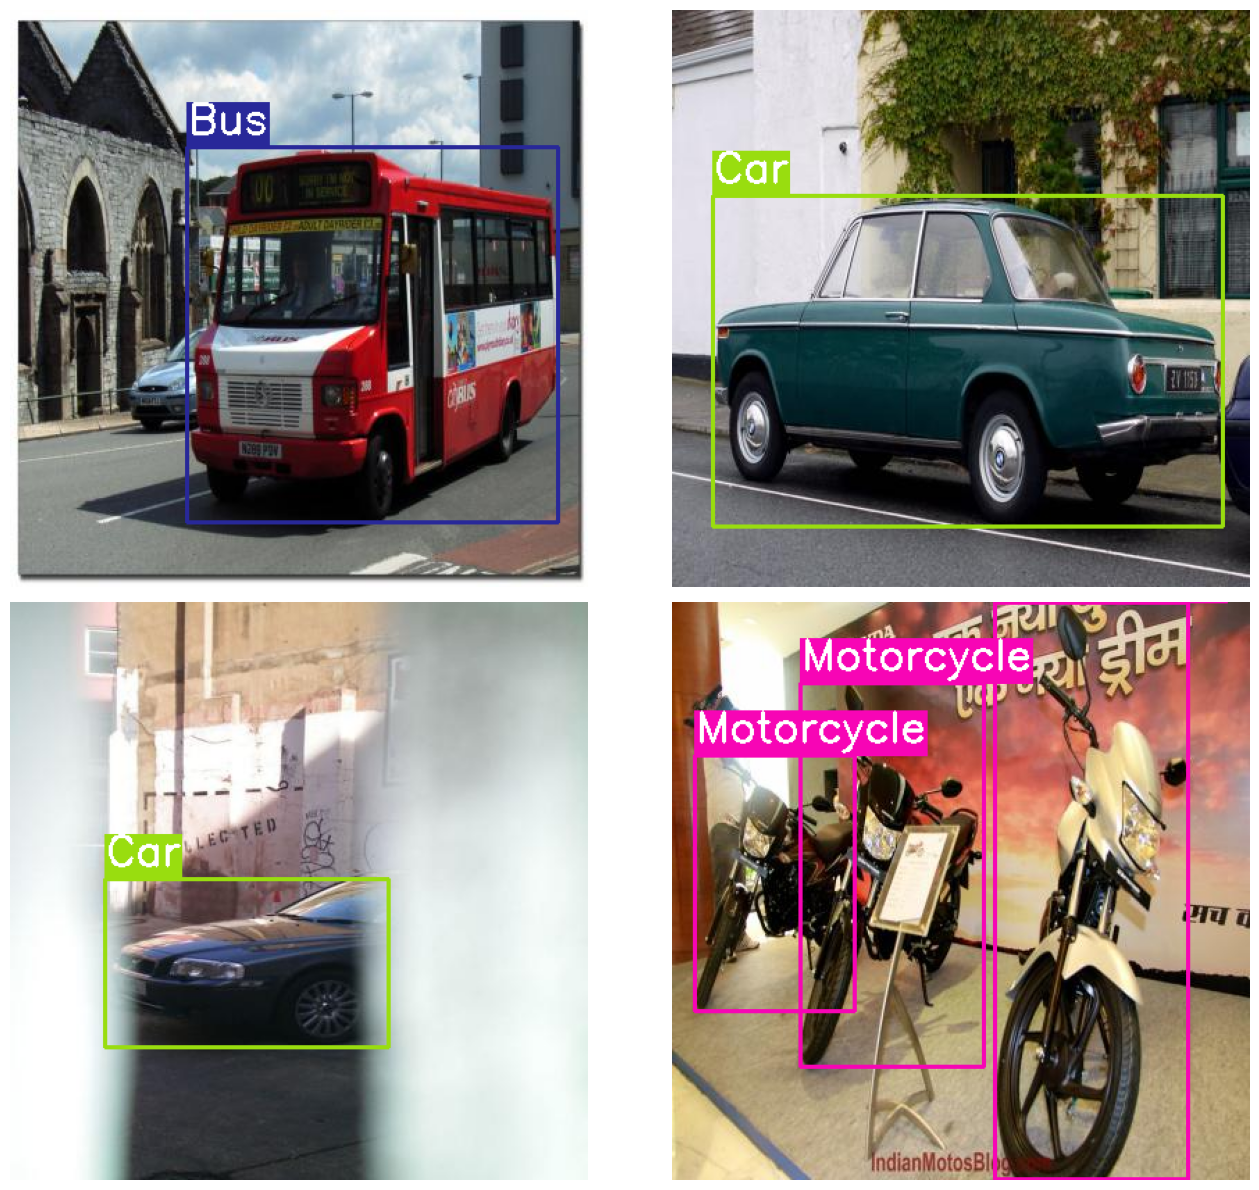

In [43]:

plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

In [44]:
def set_res_dir():
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [45]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [46]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16000, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16000 (delta 20), reused 20 (delta 12), pack-reused 15967
Receiving objects: 100% (16000/16000), 14.59 MiB | 4.07 MiB/s, done.
Resolving deltas: 100% (10986/10986), done.


In [47]:
%cd yolov5/
!pwd

/Users/palashshah/Downloads/yolov5/yolov5
/Users/palashshah/Downloads/yolov5/yolov5


In [48]:
!pip install -r requirements.txt

In [49]:
monitor_tensorboard()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [50]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 0
results_1
train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.11.5 torch-2.0.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.0

In [51]:
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [52]:

def inference(RES_DIR, data_path):

    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [53]:
def visualize(INFER_DIR):

    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [54]:
show_valid_results(RES_DIR)

events.out.tfevents.1696103066.Palashs-MBP.Dlink.32598.0
hyp.yaml
opt.yaml
weights


[]


In [55]:
download_file('https://learnopencv.s3.us-west-2.amazonaws.com/yolov5_inference_data.zip',
              'inference_data.zip')
if not os.path.exists('inference_images'):
    !unzip -q "inference_data.zip"
else:
    print('Dataset already present')

KeyboardInterrupt: 

In [ ]:

IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

Current number of inference detection directories: 0
inference_1


detect: weights=['runs/train/results_1/weights/best.pt'], source=inference_images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.11.5 torch-2.0.1 CPU

Traceback (most recent call last):
  File "/Users/palashshah/Downloads/yolov5/detect.py", line 285, in <module>
    main(opt)
  File "/Users/palashshah/Downloads/yolov5/detect.py", line 280, in main
    run(**vars(opt))
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File 

In [ ]:
visualize(IMAGE_INFER_DIR)

[]


In [ ]:
inference(RES_DIR, 'inference_videos')

Current number of inference detection directories: 1
inference_2


detect: weights=['runs/train/results_1/weights/best.pt'], source=inference_videos, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.11.5 torch-2.0.1 CPU

Traceback (most recent call last):
  File "/Users/palashshah/Downloads/yolov5/detect.py", line 285, in <module>
    main(opt)
  File "/Users/palashshah/Downloads/yolov5/detect.py", line 280, in main
    run(**vars(opt))
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File 

'inference_2'

In [ ]:
monitor_tensorboard()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 32304), started 0:01:05 ago. (Use '!kill 32304' to kill it.)

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 1
results_2


train: weights=yolov5m.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-225-gbb9706e Python-3.11.5 torch-2.0.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0